In [11]:
# !pip install datasets==2.13

In [32]:
import os
import itertools
from collections import defaultdict
import json
from functools import partial
import pathlib
import re
import unicodedata

from transformers import AutoProcessor, HubertModel
from datasets import load_dataset
import soundfile as sf
import whisperx
import torch
import pandas as pd
import numpy as np
import torch
import torchaudio


import IPython.display as ipd

os.environ["http_proxy"] = "http://proxy.ad.speechpro.com:3128"
os.environ["https_proxy"] = "http://proxy.ad.speechpro.com:3128"
os.environ["ftp_proxy"] = "http://proxy.ad.speechpro.com:3128"

In [2]:
# !mkdir RuDevices
# !tar -xf ../NIR/RuDevices.tar -C RuDevices

In [3]:
ds = pathlib.Path("RuDevices")
audios = list(ds.rglob("*.wav"))
len(audios)

93244

### HuBERT

In [4]:
# def map_to_array(batch):
#     speech, _ = sf.read(batch["file"])
#     batch["speech"] = speech
#     return batch

# ds = load_dataset("bond005/sova_rudevices", split="validation", cache_dir='../sambashare/') # TODO split train
# ds = ds.map(map_to_array)

processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
hubert_model = HubertModel.from_pretrained("facebook/hubert-large-ls960-ft").cuda()


In [5]:
# del hubert_model
# torch.cuda.empty_cache()

In [8]:
speech = sf.read(audios[0].resolve())
speech = speech[0]

In [9]:
ipd.Audio(speech, rate=16000)

In [14]:
input_values = processor([speech, speech], sampling_rate=16_000, return_tensors="pt", padding=True).input_values

In [17]:
input_values

tensor([[0.0559, 0.0980, 0.0173,  ..., 0.0232, 0.0219, 0.0217],
        [0.0559, 0.0980, 0.0173,  ..., 0.0232, 0.0219, 0.0217]])

In [18]:
hidden_states = hubert_model(input_values).last_hidden_state

In [19]:
hidden_states.shape, input_values.shape

(torch.Size([2, 164, 1024]), torch.Size([2, 52800]))

In [14]:
torch.cat([hidden_states[0][[1, 3], :], hidden_states[0][[2], :]]).shape, torch.cat([torch.tensor([]), hidden_states[0][[2], :]]).shape

(torch.Size([3, 1024]), torch.Size([1, 1024]))

In [15]:
93680 / 292 / 16000 * 1000 # длина в мс блоков обработки в HuBERT

20.051369863013697

### Whisper

In [16]:
# !pip install git+https://github.com/m-bain/whisperx.git

In [7]:
compute_type = "float16" # change to "int8" if low on GPU mem (may reduce accuracy)
device = "cuda"
whisper_model = whisperx.load_model("large-v2", device, compute_type=compute_type)

No language specified, language will be first be detected for each audio file (increases inference time).


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.9. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../home/stc/.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 2.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.0.1+cu117. Bad things might happen unless you revert torch to 1.x.


In [18]:
audio = whisperx.load_audio(audios[0].resolve())
result = whisper_model.transcribe(audio)
model_a, metadata = whisperx.load_align_model(language_code=result["language"], device=device)
result = whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=True)

Detected language: ru (0.94) in first 30s of audio...


In [20]:
whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=False)["segments"][0]

{'start': 0.41,
 'end': 2.926,
 'text': ' Но то что 40 рублей не хватает, в смысле ты ему это...',
 'words': [{'word': 'Но', 'start': 0.41, 'end': 0.45, 'score': 0.444},
  {'word': 'то', 'start': 0.491, 'end': 0.672, 'score': 0.788},
  {'word': 'что', 'start': 0.732, 'end': 0.933, 'score': 0.7},
  {'word': '40'},
  {'word': 'рублей', 'start': 1.014, 'end': 1.235, 'score': 0.835},
  {'word': 'не', 'start': 1.275, 'end': 1.336, 'score': 0.796},
  {'word': 'хватает,', 'start': 1.376, 'end': 1.859, 'score': 0.987},
  {'word': 'в', 'start': 1.879, 'end': 1.899, 'score': 0.0},
  {'word': 'смысле', 'start': 1.919, 'end': 2.302, 'score': 0.965},
  {'word': 'ты', 'start': 2.342, 'end': 2.463, 'score': 0.863},
  {'word': 'ему', 'start': 2.523, 'end': 2.745, 'score': 0.973},
  {'word': 'это...', 'start': 2.825, 'end': 2.926, 'score': 0.964}]}

### Alignment (without attention mask)

In [47]:
curr_idx = 0
curr_sum = 0

for i in result['segments'][0]['chars']:
    if 'start' in i:
        break
while curr_sum <= i['start']:
    curr_sum += 20 / 1000
    curr_idx += 1
for item in result['segments'][0]['chars']:
    if 'start' in item:
        ids_list = []
        while curr_sum >= item['start'] and curr_sum <= item['end']:
            ids_list.append(curr_idx)
            curr_idx += 1
            curr_sum += 20 / 1000
        print(f"{item['char']}: {item['start']} - {item['end']} - {ids_list}")
#     else:
#         curr_idx += 1
#         curr_sum += 20 / 1000

Н: 0.39 - 0.41 - [20]
о: 0.41 - 0.451 - [21, 22]
 : 0.451 - 0.491 - [23, 24]
т: 0.491 - 0.511 - [25]
о: 0.511 - 0.672 - [26, 27, 28, 29, 30, 31, 32, 33]
 : 0.672 - 0.692 - [34]
ч: 0.692 - 0.732 - [35, 36]
т: 0.732 - 0.873 - [37, 38, 39, 40, 41, 42, 43]
о: 0.873 - 0.954 - [44, 45, 46, 47]
 : 0.954 - 0.974 - [48]
 : 0.974 - 1.014 - [49, 50]
р: 1.014 - 1.034 - [51]
у: 1.034 - 1.115 - [52, 53, 54, 55]
б: 1.115 - 1.155 - [56, 57]
л: 1.155 - 1.175 - [58]
е: 1.175 - 1.236 - [59, 60, 61]
й: 1.236 - 1.256 - [62]
 : 1.256 - 1.276 - [63]
н: 1.276 - 1.316 - [64, 65]
е: 1.316 - 1.336 - [66]
 : 1.336 - 1.397 - [67, 68, 69]
х: 1.397 - 1.437 - [70, 71]
в: 1.437 - 1.477 - [72, 73]
а: 1.477 - 1.558 - [74, 75, 76, 77]
т: 1.558 - 1.598 - [78, 79]
а: 1.598 - 1.779 - [80, 81, 82, 83, 84, 85, 86, 87, 88]
е: 1.779 - 1.839 - [89, 90, 91]
т: 1.839 - 1.859 - [92]
 : 1.859 - 1.88 - [93]
в: 1.88 - 1.9 - [94]
 : 1.9 - 1.92 - [95]
с: 1.92 - 1.98 - [96, 97, 98]
м: 1.98 - 2.02 - [99, 100]
ы: 2.02 - 2.121 - [101, 102, 

## Make-DataSet

In [ ]:
# # Предположим, что 'whisper_alignments' - это список словарей,
# # где каждый словарь содержит 'char' и временные метки 'start' и 'end' для каждого символа
# # И 'hidden_states' - это тензор из HuBERT, где каждый фрейм соответствует 20 мс аудио

# aligned_hidden_states = []

# for alignment in whisper_alignments:
#     start_frame = int(alignment['start'] * 1000 // 20)
#     end_frame = int(alignment['end'] * 1000 // 20)
    
#     # Получаем средний вектор скрытых состояний HuBERT для временного диапазона символа
#     char_hidden_state = hidden_states[start_frame:end_frame].mean(dim=0)
    
#     aligned_hidden_states.append({
#         'char': alignment['char'],
#         'hidden_state': char_hidden_state
#     })

In [30]:
def alignment(result, outputs, hidden_state, audio):
    
    curr_idx = 0
    curr_sum = 0

    for i in result:
        if 'start' in i:
            break
    while curr_sum <= i['start']:
        curr_sum += 20 / 1000
        curr_idx += 1
    for item in result:
        if 'start' in item:
            ids_list = []
            while curr_sum >= item['start'] and curr_sum <= item['end']:
                ids_list.append(curr_idx)
                curr_idx += 1
                curr_sum += 20 / 1000
            if item['char'].lower() not in outputs:
                outputs[item['char'].lower()] = {"contents_ids": [], "audio": [], "count": 0}
            # last = outputs[item['char'].lower()]["contents"]
            # outputs[item['char'].lower()]["contents"] = torch.cat([hidden_state[ids_list, :], last])
            outputs[item['char'].lower()]["contents_ids"].append(ids_list)
            outputs[item['char'].lower()]["audio"].append(audio) # TDOD: set
            outputs[item['char'].lower()]["count"] += 1
    
    return 

In [2]:
# # file | phonems | content
# from IPython.display import clear_output

# ds = pathlib.Path("RuDevices")
# audios = list(ds.rglob("*.wav"))

# global_dict = {}

# for i, audio_path in enumerate(audios):
    
#     audio = whisperx.load_audio(audio_path.resolve())
    
#     # hubert infer
#     input_values = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True).input_values
#     hidden_states = hubert_model(input_values).last_hidden_state
    
#     # whisper infer
#     try:
#         result = whisper_model.transcribe(audio)
#         if result["language"] != "ru":
#             continue
#         model_a, metadata = whisperx.load_align_model(language_code="ru", device=device) # result["language"]
#         result = whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=True)
    
#         if not result['segments']:
#             continue 
        
#         # alighnment
#         alignment(result['segments'][0]['chars'], global_dict, hidden_states[0], audio_path.resolve())
#     except:
#         continue

#     clear_output(wait=False)

In [3]:
# import pandas as pd
# pd.DataFrame(global_dict).to_csv('dataset.csv')

In [4]:
dataset = pd.read_csv('dataset.csv')

In [22]:
dataset

,Unnamed: 0,н,о,,т,ч,р,у,б,л,...,ш,з,ё,щ,ю,г,-,ц,ф,ъ
0,contents_ids,"[[20], [64, 65], [136, 137], [35, 36], [136, 1...","[[21, 22], [26, 27, 28, 29, 30, 31, 32, 33], [...","[[23, 24], [34], [48], [49, 50], [63], [67, 68...","[[25], [37, 38, 39, 40, 41, 42, 43], [78, 79],...","[[35, 36], [64, 65], [159, 160, 161, 162, 163,...","[[51], [18, 19], [61, 62], [87, 88], [110, 111...","[[52, 53, 54, 55], [132, 133, 134, 135, 136, 1...","[[56, 57], [113, 114], [133, 134, 135], [207, ...","[[58], [110, 111], [79, 80], [121, 122, 123, 1...",...,"[[79, 80, 81], [165, 166], [260, 261, 262, 263...","[[132, 133, 134, 135], [301, 302, 303, 304, 30...","[[188, 189, 190, 191, 192, 193, 194, 195, 196,...","[[240, 241], [141], [20], [16], [71, 72], [60,...","[[72, 73, 74, 75, 76, 77], [73, 74, 75, 76], [...","[[156], [223, 224, 225, 226, 227, 228, 229, 23...","[[91], [100], [200, 201], [24], [228], [11, 12...","[[185, 186], [215, 216, 217, 218], [38, 39], [...","[[66, 67], [202, 203], [54, 55, 56, 57], [38, ...","[[214, 215, 216], [91, 92, 93, 94], [204, 205,..."
1,audio,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...
2,count,36182,65113,106076,45473,10749,22432,18070,12309,21788,...,4580,8223,2159,1974,4214,7797,2137,1808,1190,197


In [4]:
# ds["н"][]

In [43]:
ds = {}
for col in dataset:
    if col not in ds:
        ds[col] = {}
    ds[col]["contents_ids"] = dataset[col][0]
    ds[col]["audio"] = dataset[col][1]

del ds['Unnamed: 0']

for char in ds:
    ds[char]["audio"] = [*map(lambda x: x.replace("),", "").replace("'", "").strip(), ds[char]["audio"].split("PosixPath(")[1:])]


import re

for char in ds:
    arrays = re.findall(r"\[[\d, ]+\]", ds[char]["contents_ids"]) # Это массивы в виде строк
    content_ids = [[int(number) for number in re.findall(r"\d+", array)] for array in arrays] # Превращение строчных массивов к реальным числовым
    ds[char]["contents_ids"] = content_ids

In [61]:
dataset = pd.read_csv('dataset.csv').to_dict() # правильно обработать !

In [1]:
import sys

In [51]:
class HuBERT_Processor:
    def __init__(self, contents):
        self.contents = contents
        self.processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
        self.hubert_model = HubertModel.from_pretrained("facebook/hubert-large-ls960-ft")
        print(self.hubert_model.device)

    def get_content(self, char):
        res = []
        char = self.contents[char]
        audio_list = char["audio"]
        content_ids = char["contents_ids"]
        for audio_path, content in zip(audio_list, content_ids):
            audio = whisperx.load_audio(audio_path) # .resolve()
            input_values = self.processor(audio, sampling_rate=16000, return_tensors="pt", padding=True).input_values
            hidden_states = self.hubert_model(input_values).last_hidden_state[0]
            res.append(hidden_states[content, :])
            print(sys.getsizeof(res) / 1024 / 1024)
        return res



In [52]:
hu_proc = HuBERT_Processor(ds)

cpu


In [4]:
# res = hu_proc.get_content('н')

In [ ]:
for chr in chars:
    for audio_path in audio_path_list:
        yield processor(data[char][audio_path])[data[char][audio_path][content]]

In [62]:
mean_audio_counts = []
mean_freqs = []
for char in ds:
    mean_audio_counts.append(len(set(ds[char]["audio"])))
    mean_freqs.append(len(ds[char]["audio"]))
from statistics import mean
len(ds), mean(mean_audio_counts), mean(mean_freqs)

(35, 8488.314285714287, 19435.314285714285)

In [58]:
len(set(ds["о"]["audio"]))

16668

# Work

In [5]:
# Можно ли инференсить по батчам?
# Clustering https://github.com/voicepaw/so-vits-svc-fork/blob/main/src/so_vits_svc_fork/cluster/train_cluster.py#L18

In [48]:
class AudioLoad(torch.utils.data.Dataset):
    
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        waveform = whisperx.load_audio(self.dataset[idx])
        return waveform

def hubert_processor_collate(batch, processor):
    # wave_forms, _ = zip(*batch) if batch consist of multiple items, e.g. (batch, sr)
    input_values = processor(batch, sampling_rate=16_000, return_tensors="pt", padding=True).input_values
    return input_values

class HuBERTInference(torch.nn.Module):
    
    def __init__(self, hubert):
        super().__init__()
        self.hubert = hubert

    @torch.inference_mode()
    def forward(self, x):
        x = self.hubert(x)
        x = x.last_hidden_state
        return x
        

class WhisperXInference(torch.nn.Module):
    
    def __init__(self, compute_type, device, language):
        super().__init__()
        self.device = device
        self.language = language
        self.whisper = whisperx.load_model("large-v2", self.device, compute_type=compute_type)
        align_model, metadata = whisperx.load_align_model(language_code=self.language, device=self.device)
        self.align_model = align_model
        self.metadata = metadata

    @torch.inference_mode()
    def forward(self, x):
        output = self.whisper.transcribe(x)
        x = whisperx.align(output["segments"], self.align_model, self.metadata, x, self.device, return_char_alignments=True)
        return x

def is_cyrillic(char):
    return 'CYRILLIC' in unicodedata.name(char)

def align_to_hubert(whisper_output, audio_path, aligns):
    
    for alignment in whisper_output:
        try:
            char = alignment['char'].lower()
            if not is_cyrillic(char):
                raise Exception()
            start = int(alignment['start'] * 1000 // 20)
            end = int(alignment['end'] * 1000 // 20) + 1
            aligns[char][audio_path].append([*range(start, end)])
        except:
            continue
    return 

def defaultdict_to_dict(d):
    if isinstance(d, defaultdict):
        d = {k: defaultdict_to_dict(v) for k, v in d.items()}
    return d

def postprocess_whisper_output(output):
    segments = output.get("segments", [])
    if segments:
        if not isinstance(segments[0], dict):
            return []
        return segments[0].get("chars", [])
    return []

def buid_json(aligns, file_name):
    with open(file_name, mode='w+', encoding='utf-8') as file:
        json.dump(defaultdict_to_dict(aligns), file, indent=4, ensure_ascii=False)
        
# processor_ = partial(processor, sampling_rate=16_000, return_tensors="pt", padding=True)
# collate = lambda x:  processor_(list(x)).input_values

In [6]:
processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
hubert_model = HubertModel.from_pretrained("facebook/hubert-large-ls960-ft")
whisper = WhisperXInference("float16", "cuda", "ru").cuda()

No language specified, language will be first be detected for each audio file (increases inference time).


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.9. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../home/stc/.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 2.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.0.1+cu117. Bad things might happen unless you revert torch to 1.x.


In [7]:
ds = pathlib.Path("RuDevices")
audio_dataset = list(ds.rglob("*.wav"))
audio_dataset = list(map(lambda x: x.as_posix(), audio_dataset))

In [139]:
# torch.cuda.empty_cache()

In [8]:
%%time 

hubert_audio_dataset = AudioLoad(audio_dataset)
collate = partial(hubert_processor_collate, processor=processor)
hubert_audio_loader = torch.utils.data.DataLoader(hubert_audio_dataset, batch_size=16, collate_fn=collate)

hubert_inf = HuBERTInference(hubert_model).cuda()
hubert_inf.eval()


hubert_inf(next(iter(hubert_audio_loader)).cuda());

CPU times: user 696 ms, sys: 1.1 s, total: 1.8 s
Wall time: 3.81 s


In [9]:
%%time

whisper_ds = AudioLoad(audio_dataset)
whisper_audio_loader = torch.utils.data.DataLoader(whisper_ds, batch_size=1, collate_fn=lambda batch: batch)
whisper.eval()
postprocess_whisper_output(whisper(next(iter(whisper_audio_loader))[0]));

Detected language: ru (0.94) in first 30s of audio...
CPU times: user 731 ms, sys: 164 ms, total: 895 ms
Wall time: 926 ms


In [11]:
aligns = defaultdict(lambda: collections.defaultdict(list))
data = next(iter(whisper_audio_loader))[0]
result = postprocess_whisper_output(whisper(data))
align_to_hubert(result, whisper_ds.dataset[0], aligns)

Detected language: ru (0.94) in first 30s of audio...


In [ ]:
# with open('minimaxDataset.json', mode='w+', encoding='utf-8') as file:
#     json.dump(defaultdict_to_dict(aligns), file, indent=4, ensure_ascii=False)

In [12]:
assert isinstance(pd.read_json("minimaxDataset.json")["Н"][0], list)

In [ ]:
aligns = defaultdict(lambda: defaultdict(list)) # TODO: make with concurrency/multiprocessing
for i, data in enumerate(whisper_audio_loader):
    result = postprocess_whisper_output(whisper(data[0]))
    align_to_hubert(result, whisper_ds.dataset[i], aligns)
buid_json(aligns, 'dataset.json')

Detected language: ru (0.98) in first 30s of audio...
Detected language: ru (0.99) in first 30s of audio...
Detected language: ru (0.99) in first 30s of audio...
Detected language: ru (0.95) in first 30s of audio...
Detected language: ru (0.92) in first 30s of audio...
Detected language: ru (0.98) in first 30s of audio...
Detected language: ru (0.99) in first 30s of audio...
Detected language: ru (0.99) in first 30s of audio...
Detected language: ru (1.00) in first 30s of audio...
Detected language: ru (0.96) in first 30s of audio...
Detected language: ru (0.96) in first 30s of audio...
Detected language: ru (0.99) in first 30s of audio...
Detected language: ru (0.99) in first 30s of audio...
Detected language: ru (0.98) in first 30s of audio...
Detected language: ru (0.94) in first 30s of audio...
Detected language: ru (0.99) in first 30s of audio...
Detected language: ru (0.99) in first 30s of audio...
Detected language: ru (0.98) in first 30s of audio...
Detected language: ru (0.95)

In [53]:
len(aligns)

33

In [56]:
assert i == 93243

In [62]:
dataset = pd.read_json('dataset.json')

In [ ]:
# Для каждого символа - количество аудио

In [104]:
sum((~dataset.T.loc['н'].isna()))

68747

In [99]:
stat = {}
for char in dataset:
    stat[char] = sum((~dataset.T.loc[char].isna()))

{'н': 68747,
 'о': 79756,
 'т': 75343,
 'ч': 37410,
 'р': 58271,
 'у': 51153,
 'б': 40407,
 'л': 57460,
 'е': 75440,
 'й': 24079,
 'х': 18969,
 'в': 56275,
 'а': 76112,
 'с': 60886,
 'м': 50194,
 'ы': 33325,
 'э': 14454,
 'ь': 41351,
 'к': 52713,
 'я': 44635,
 'и': 66441,
 'п': 50139,
 'д': 49998,
 'ж': 22252,
 'ш': 18569,
 'з': 30621,
 'ё': 9028,
 'щ': 8620,
 'ю': 16317,
 'г': 28686,
 'ц': 7849,
 'ф': 5005,
 'ъ': 943}

In [121]:
import copy
copy_stat = copy.deepcopy(stat)

for key, value in copy_stat.items():
    copy_stat[key] = [value]

df_ = pd.DataFrame(copy_stat, index=["Audio count"])

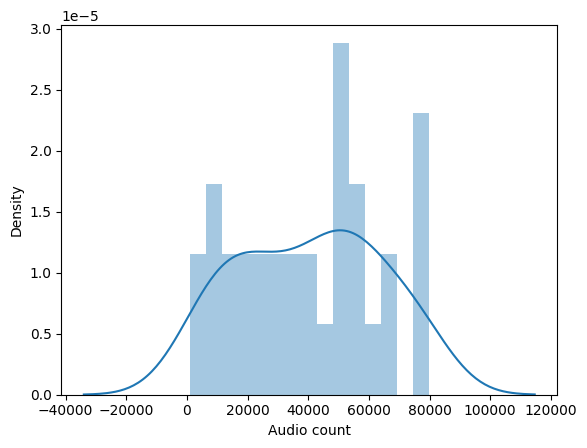

In [134]:
import seaborn as sns
ax = sns.distplot(df_.T, bins=15);
ax.set_xlabel("Audio count");

In [113]:
df_.T.describe()

,0
count,33.000000
mean,40346.909091
std,23415.912840
min,943.000000
25%,18969.000000
50%,41351.000000
75%,57460.000000
max,79756.000000


In [89]:
stat = {}
for char in dataset:
    stat[char] = sum((~dataset.T.loc[char].isna()))

17

In [151]:
np.mean(dataset['н'][~dataset['н'].isna()].map(lambda x: len(x)))

2.526132049398519

In [71]:
len(dataset['н'].loc['RuDevices/0/0/679561f7-3e55-4119-b597-dbb6ab665f98.wav'])

2

In [103]:
dataset

,н,о,т,ч,р,у,б,л,е,й,...,ж,ш,з,ё,щ,ю,г,ц,ф,ъ
RuDevices/0/0/679561f7-3e55-4119-b597-dbb6ab665f98.wav,"[[19, 20], [63, 64, 65]]","[[20, 21, 22], [25, 26, 27, 28, 29, 30, 31, 32...","[[24, 25], [36, 37, 38, 39, 40, 41, 42, 43], [...","[[34, 35, 36]]","[[50, 51]]","[[51, 52, 53, 54, 55], [131, 132, 133, 134, 13...","[[55, 56, 57]]","[[57, 58], [109, 110, 111]]","[[58, 59, 60, 61], [65, 66], [88, 89, 90, 91],...","[[61, 62]]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RuDevices/0/0/fe60a55e-5bfc-4de7-99fd-9a88081659c5.wav,"[[135, 136, 137]]","[[3, 4, 5], [19, 20, 21, 22, 23, 24], [55, 56,...","[[1, 2, 3], [9, 10], [53, 54, 55]]",NaN,"[[17, 18, 19], [60, 61, 62], [86, 87, 88], [10...",NaN,NaN,"[[78, 79, 80], [120, 121, 122, 123, 124, 125]]","[[7, 8], [74, 75, 76, 77, 78], [104, 105, 106]...",NaN,...,"[[125, 126, 127, 128]]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RuDevices/0/0/203b95bd-8f75-44b1-b53d-ad3c18d5a9b9.wav,"[[34, 35, 36], [136, 137, 138], [250, 251, 252...","[[47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, ...","[[68, 69, 70, 71, 72], [94, 95, 96], [221, 222...","[[158, 159, 160, 161, 162, 163, 164]]","[[44, 45, 46, 47], [72, 73]]","[[150, 151, 152, 153, 154, 155, 156, 157, 158]...","[[206, 207, 208, 209], [233, 234, 235, 236, 23...","[[147, 148, 149, 150]]","[[96, 97, 98, 99, 100, 101], [166, 167, 168, 1...","[[89, 90, 91, 92, 93, 94]]",...,"[[115, 116, 117, 118, 119]]","[[164, 165, 166], [259, 260, 261, 262, 263, 26...","[[132, 133, 134, 135, 136]]","[[187, 188, 189, 190, 191, 192, 193, 194, 195,...","[[239, 240, 241]]",NaN,NaN,NaN,NaN,NaN
RuDevices/0/0/1e71ba09-9fe1-432f-ae99-25df0f523027.wav,"[[2, 3], [10, 11], [23, 24, 25], [54, 55]]","[[3, 4, 5, 6, 7, 8], [19, 20, 21, 22, 23], [55...","[[81, 82, 83, 84]]","[[68, 69, 70]]",NaN,"[[70, 71, 72, 73, 74, 75], [86, 87, 88, 89, 90...",NaN,NaN,"[[11, 12, 13, 14], [42, 43, 44, 45, 46], [92, ...",NaN,...,NaN,"[[46, 47, 48], [95, 96, 97]]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RuDevices/0/0/4a41249b-5ed9-43a2-a6ee-4f800cd19907.wav,"[[77, 78], [172, 173, 174, 175], [229, 230, 23...","[[20, 21, 22, 23], [188, 189, 190, 191, 192, 1...","[[23, 24, 25, 26], [93, 94, 95], [114, 115, 11...","[[180, 181, 182, 183, 184, 185, 186], [385, 38...","[[30, 31, 32], [99, 100], [116, 117, 118], [43...","[[48, 49, 50, 51], [392, 393, 394, 395], [403,...","[[401, 402, 403]]","[[429, 430]]","[[37, 38, 39, 40, 41, 42, 43, 44], [78, 79, 80...","[[193, 194, 195, 196, 197, 198, 199], [236, 23...",...,"[[312, 313, 314, 315, 316, 317]]","[[217, 218, 219]]","[[300, 301, 302, 303, 304, 305]]",NaN,NaN,"[[71, 72, 73, 74, 75, 76, 77]]",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RuDevices/e/a/623d911d-68da-46bb-994a-5fe1c4136279.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RuDevices/e/5/dc90f9ac-d504-46fd-a032-b75f36fe05fe.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[[28, 29, 30, 31, 32, 33, 34, 35]]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RuDevices/e/7/e1fed3f5-e459-44d0-991e-19afb138ca79.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RuDevices/3/0/1b2af74f-aa2a-4256-bcea-5a55c8eb067b.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
aligns


KeyboardInterrupt

